import libs and helpers, check versions

In [1]:
import glob
import pandas as pd

import matplotlib.pyplot as plt
import contextily as ctx

# DHI libs
import mikeio

from fmskill.model import ModelResult
from fmskill import PointObservation, Connector


# ignore warnings (as they can get annoying with mikeio pre-release versions)
import warnings
warnings.filterwarnings("ignore")

# check out versions (fmskill and mikeio compatability 0.7.dev0 - 0.12.2)
#!pip install mikeio == 0.12.2
mikeio.__version__

'0.12.2'

In [2]:
import fmskill
fmskill.__version__

'0.7.dev0'

In [3]:
# helper functions
def annotate_scatterplot(df, x='x', y='y', acol='name', c='w', fs=12, fw='normal', rot=45):
    """
    takes a dataframe and annotates x, y coordinates of scatterplot for axis ax
    """
    # loop throgh all rows of dataframe
    for i, point in df.iterrows():
        ax.text(point[x], point[y], str(point[acol]), 
        color=c, fontsize=fs, fontweight=fw, rotation=rot)

# Evaluating skill of (multiple) model(s)


## Specification of folders and getting acquainted with output data

In [4]:
# specify setup folder and suffix to look for
modelfold = 'D:\mesh_calib'
setupfold = modelfold+'\setups'
obsfold = modelfold+'\observations'

# get all setups from folder
setups = glob.glob(setupfold+'\*.m21fm')
setups = setups[1:] # omitting prerun / hotstart here


In [5]:
# just take last setup and get output information
pfs = mikeio.Pfs(setups[-1])
pfs.data.HD.get_outputs()

,file_name,include,type,format,first_time_step,last_time_step,use_end_time,time_step_frequency
1,initial_condition_20160622_1200.dfsu,0,1,2,1440,1440,1,1
2,WaterLevel.dfs0,1,1,0,0,1440,1,1
3,2D.dfsu,1,1,2,0,1440,1,5
4,Velocity.dfs0,1,1,0,0,1440,1,1
5,Teufelsbrueck_Profile.dfs1,1,1,1,0,1440,1,5
6,Finkenwerder_Point.dfs0,1,1,0,0,1440,1,1
7,Finkenwerder_1D_Profile.dfs1,1,1,1,0,1440,1,1


... continuing with 2d output as model result.

## Comparing model results and observations

define point observations and their coordinates (see setup notebook)

In [6]:
# define observations (as they remain constant do manually here)
o1 = PointObservation(obsfold + '\WL_Blankenese.dfs0', item=1, x=552662.0, y=5934417.0, name="BLK")
o2 = PointObservation(obsfold + '\WL_Seemannshoeft_2015-2019_11.dfs0', item=0, x=558308.0, y=5932945.0, name="SMH")
o3 = PointObservation(obsfold + '\WL_StPauli_2015-2019_11.dfs0', item=0, x=564210.0, y=5933155.0, name="NE_STP")
o4 = PointObservation(obsfold + '\WL_Harburg_NHN.dfs0', item=1, x=565854.0, y= 5925460.0, name="SE_HRB")
o5 = PointObservation(obsfold + '\WL_Schoepfstelle_2015-2020.dfs0', item=0, x=570241.0, y=5929353.0, name="NE_SST")

get list with model results

In [19]:
# loop throuh all model results and aggregate in list (automatically so easy rerun when updated)
mr_list = []
for mdl in setups:
    mr = ModelResult(mdl + ' - Result Files\\2D.dfsu', name=mdl.split('\\')[-1], item=0)
    mr_list.append(mr)

print('comparing {} different model runs'.format(len(mr_list)))

comparing 11 different model runs


connect model results and observations

In [8]:
# connect model and observation data
con = Connector([o1, o2, o3, o4, o5], mr_list)

## provide map overview of compared data

below you can see a nice overview of the model domain and observations used for comparison with model results

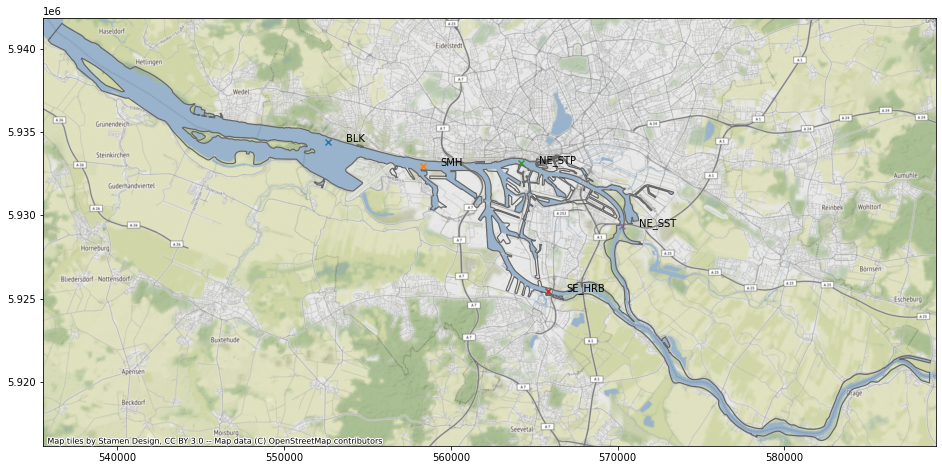

In [9]:
ax = con.plot_observation_positions(figsize=(16,8));
ctx.add_basemap(ax=ax,crs='EPSG:25832')#, source = ctx.providers.Stamen.Toner)

## Quantitative evaluation
check which times model output and observations cover

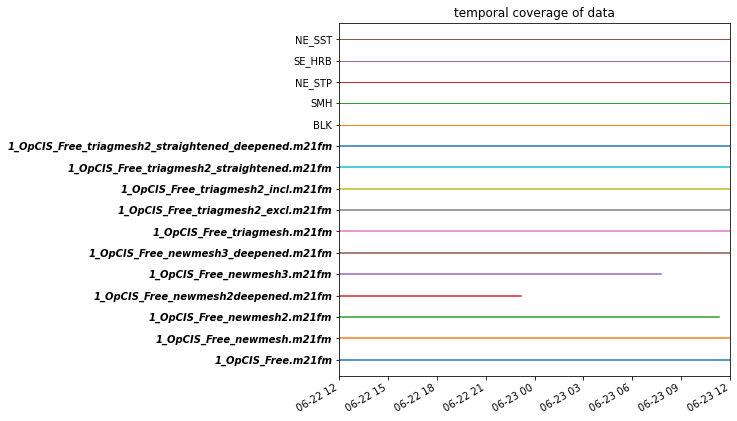

In [10]:
con.plot_temporal_coverage(title='temporal coverage of data');

In [11]:
# get collection of comparisons
cc = con.extract()

plot timeseries for **one** station

<AxesSubplot:title={'center':'BLK'}, ylabel='Surface Elevation [m]'>

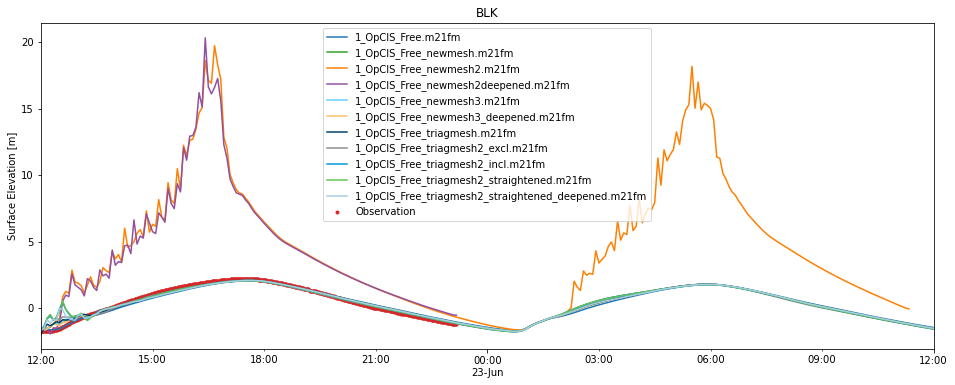

In [12]:
cc['BLK'].plot_timeseries(figsize = (16,6))

bit unclear which models are the worst - assess in table overview

In [13]:
s = cc.skill()
s.sel(observation='BLK').style()

,observation,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,,
1_OpCIS_Free.m21fm,BLK,671,-0.051,0.186,0.179,0.162,0.991,0.136,0.975
1_OpCIS_Free_newmesh.m21fm,BLK,671,-0.012,0.158,0.157,0.136,0.996,0.120,0.982
1_OpCIS_Free_newmesh2.m21fm,BLK,671,4.078,5.578,3.805,4.078,0.801,2.893,-21.211
1_OpCIS_Free_newmesh2deepened.m21fm,BLK,671,3.943,5.402,3.693,3.945,0.807,2.807,-19.832
1_OpCIS_Free_newmesh3.m21fm,BLK,671,-0.019,0.158,0.157,0.131,0.996,0.119,0.982
1_OpCIS_Free_newmesh3_deepened.m21fm,BLK,671,-0.024,0.147,0.145,0.128,0.997,0.110,0.985
1_OpCIS_Free_triagmesh.m21fm,BLK,671,-0.012,0.165,0.164,0.129,0.995,0.125,0.981
1_OpCIS_Free_triagmesh2_excl.m21fm,BLK,671,-0.008,0.226,0.226,0.146,0.987,0.172,0.964
1_OpCIS_Free_triagmesh2_incl.m21fm,BLK,671,0.030,0.312,0.311,0.173,0.973,0.236,0.930


evaluate at **all stations**

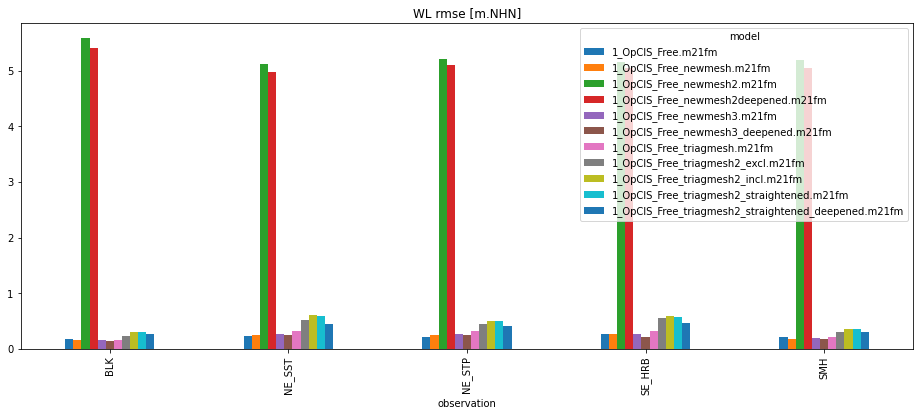

In [14]:
s.plot_bar('rmse', title='WL rmse [m.NHN]', figsize=(16,6));

select **only the better performing models for comparison**

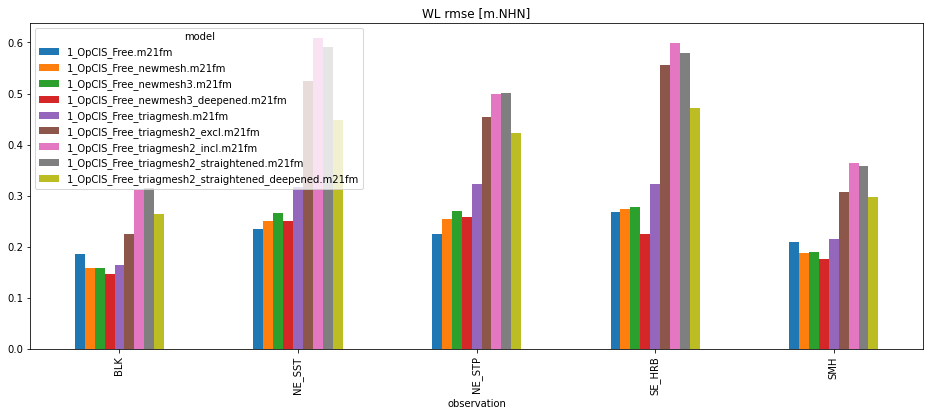

In [15]:
s.sel('rmse<1').plot_bar('rmse', title='WL rmse [m.NHN]', figsize=(16,6));

**evaluate best model** in Detail

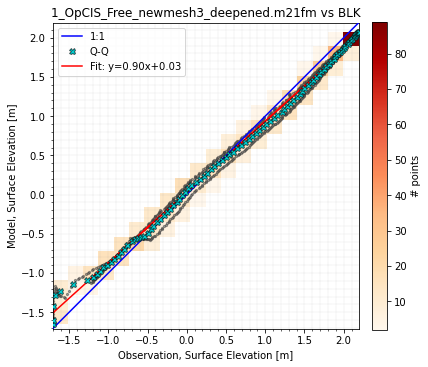

In [16]:
#cc.scatter(model='1_OpCIS_Free_newmesh3_deepened.m21fm', start='2017-10-28', cmap='OrRd', figsize=(6,7))
cc['BLK'].scatter(model='1_OpCIS_Free_newmesh3_deepened.m21fm', cmap='OrRd', figsize=(6,7))

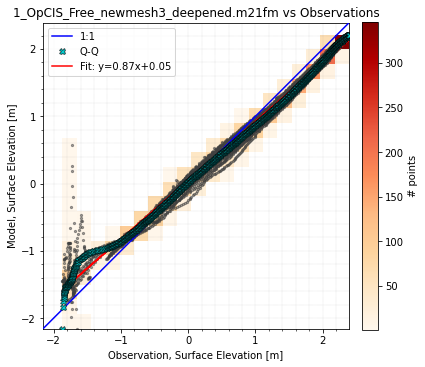

In [17]:
cc.scatter(model='1_OpCIS_Free_newmesh3_deepened.m21fm', cmap='OrRd', figsize=(6,7))

conclusion: some improvements for low tide < - 1 m NHN should be conducted 